In [1]:
# Import Modules
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from torch_scatter import scatter_mean
import torch_geometric.transforms as T
from torch_geometric.utils import normalized_cut, to_dense_batch, from_networkx
from torch_geometric.nn import MetaLayer, SplineConv, max_pool, GlobalAttention
from torch_geometric.transforms import FaceToEdge, Cartesian
from torch_geometric.data import Batch, Data, Dataset
from utils.distributions import *
from models_orig import LigandNet, TargetNet, AlphaDock, compute_cluster_batch_index, mdn_loss_fn

from utils import mol2graph
from utils.data import read_ply
from rdkit import Chem
import networkx as nx
import py3Dmol
#import pymesh
from plyfile import PlyData

/home/dell4/miniconda3/envs/gnn_train/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Prepare data files for training
import os
from tqdm import tqdm
DATA_PATH = '/home/dell4/king/202112_graphDrug/data_v2/PDBbind_v2020_other_PL/v2020-other-PL_minimized/'
data_dict = dict.fromkeys(['target', 'mol'], [])

import pickle 
def save_list(mylist, f_name):
    with open('/home/dell4/king/202112_graphDrug/data_v2/%s.pkl'%(f_name), 'wb') as f:
        pickle.dump(mylist, f)
    return None

def load_data(f_path):
    with open(f_path, 'rb') as f:
        mynewlist = pickle.load(f)
        return mynewlist

if os.path.exists('/home/dell4/king/202112_graphDrug/data_v2/v2020-other-PL_minimized.pkl'):
    print('Found saved data file. loading...')
    processed_data = load_data('/home/dell4/king/202112_graphDrug/data_v2/v2020-other-PL_minimized.pkl')
    print('Found %s complexes'%(len(processed_data)))

else:
    processed_data = []
    mol_ntwk_set, target_mesh_set = [], []
    for ID in tqdm(os.listdir(DATA_PATH)):
        #if os.path.exists(DATA_PATH+ID+'/'+ID+'_protein.ply'):
        try:
            target_ply = DATA_PATH+ID+'/'+ID+'_protein.ply'
            m = Chem.rdmolfiles.MolFromMol2File(DATA_PATH+'%s/%s_ligand.mol2'%(ID, ID), sanitize=False, cleanupSubstructures=False)

            # target_mesh = read_ply(target_ply)
            mol_ntwk = from_networkx(mol2graph.mol_to_nx(m))
            mol_ntwk_set.append(mol_ntwk)

            target_mesh = Cartesian()(FaceToEdge()(read_ply(target_ply)))
            target_mesh_set.append(target_mesh)

            # Dump data into a list
            processed_data.append((target_mesh, mol_ntwk))
        #else:
        except:
            pass
            #print('.ply file not available for', ID)
    save_list(processed_data, 'v2020-other-PL_minimized')
    print('Saved %s complexes'%(len(processed_data)))

Found saved data file. loading...
Found 13785 complexes


In [3]:
# Splot data and generate loaders
from torch_geometric.loader import DataLoader
split = int(len(processed_data)*0.8)
train_data = processed_data[:split]
test_data = processed_data[split:]
print('Complexes in training set:', len(train_data))
print('Complexes in test set:', len(test_data))

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

ligand_model = LigandNet(28, residual_layers=10, dropout_rate=0.10)
target_model = TargetNet(3, residual_layers=10, dropout_rate=0.10)
model = AlphaDock(ligand_model, target_model, hidden_dim=64, n_gaussians=10, dropout_rate=0.10, dist_threhold=7.).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,
                              betas=(0.9, 0.999), 
                              eps=1e-06, weight_decay=0.01)

epochs = 50
batch_size = 8
save_each=50
aux_weight = 0.001
losses = []
loader_train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Complexes in training set: 11028
Complexes in test set: 2757
Device: cuda


In [3]:
len(processed_data)

1778

In [4]:
# # Save model image
# from torchviz import make_dot
# y = model(loader_train.dataset[1][1].to(device), loader_train.dataset[1][0].to(device))
# make_dot(y, params=dict(model.named_parameters())).render("attached", format="png")

In [4]:
# %%time
# from datetime import datetime
# now = datetime.now()
# print(now.strftime("Start date: %d/%m/%Y at %H:%M:%S"))

def train():
    model.train()
    #scaler = torch.cuda.amp.GradScaler()

    total_loss, mdn_loss, atom_loss, bond_loss, count = 0, 0, 0, 0, 0
    for data in loader_train:
        try:
            count+=1
            #print(count)
            optimizer.zero_grad()
            
            #with torch.cuda.amp.autocast(enabled=True):
            target, ligand = data
            ligand, target = ligand.to(device), target.to(device)
            atom_labels = torch.argmax(ligand.x, dim=1, keepdim=False)
            bond_labels = torch.argmax(ligand.edge_attr, dim=1, keepdim=False)
                
            with torch.autocast(device_type='cuda'):
                pi, sigma, mu, dist, atom_types, bond_types, batch = model(ligand, target)
                # if count==68: 
                #     print(pi, sigma, mu, dist)
                
                mdn = mdn_loss_fn(pi, sigma, mu, dist)
                mdn = mdn[torch.where(dist <= model.dist_threhold)[0]]
                mdn = mdn.mean()
                atom = F.cross_entropy(atom_types, atom_labels)
                bond = F.cross_entropy(bond_types, bond_labels)
                loss = mdn + (atom * aux_weight) + (bond * aux_weight)
                #print('Total loss:', loss)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * (ligand.batch.max().item() + 1)
            mdn_loss += mdn.item() * (ligand.batch.max().item() + 1)
            atom_loss += atom.item() * (ligand.batch.max().item() + 1)
            bond_loss += bond.item() * (ligand.batch.max().item() + 1)
            
            #print('Step, Total Loss: {:.3f}, MDN: {:.3f}'.format(total_loss, mdn_loss))
            if np.isinf(mdn_loss) or np.isnan(mdn_loss): break
        except:
            print('Error at',epoch, count)
            pass
    return total_loss / len(loader_train.dataset), mdn_loss / len(loader_train.dataset), atom_loss / len(loader_train.dataset), bond_loss / len(loader_train.dataset)

@torch.no_grad()
def test(loader):
    model.eval()

    #loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    total_loss, mdn_loss, atom_loss, bond_loss = 0, 0, 0, 0
    for data in loader:
        try:
            target ,ligand = data
            ligand, target = ligand.to(device), target.to(device)
            atom_labels = torch.argmax(ligand.x, dim=1, keepdim=False)
            bond_labels = torch.argmax(ligand.edge_attr, dim=1, keepdim=False)
            
            pi, sigma, mu, dist, atom_types, bond_types, batch = model(ligand, target)
                
            mdn = mdn_loss_fn(pi, sigma, mu, dist)
            mdn = mdn[torch.where(dist <= model.dist_threhold)[0]]
            mdn = mdn.mean()
            atom = F.cross_entropy(atom_types, atom_labels)
            bond = F.cross_entropy(bond_types, bond_labels)
            loss = mdn + (atom * aux_weight) + (bond * aux_weight)
            
            total_loss += loss.item() * (ligand.batch.max().item() + 1)
            mdn_loss += mdn.item() * (ligand.batch.max().item() + 1)
            atom_loss += atom.item() * (ligand.batch.max().item() + 1)
            bond_loss += bond.item() * (ligand.batch.max().item() + 1)
        except:
            pass

    return total_loss / len(loader.dataset), mdn_loss / len(loader.dataset), atom_loss / len(loader.dataset), bond_loss / len(loader.dataset)

import pandas as pd
prev_test_total_loss = 1000
for epoch in range(1, epochs + 1):
    total_loss, mdn_loss, atom_loss, bond_loss = train()
    #print(total_loss)
    if np.isinf(mdn_loss) or np.isnan(mdn_loss): 
        print('Inf ERROR')
        break
    test_total_loss, test_mdn_loss, test_atom_loss, test_bond_loss = test(loader_test)
    losses.append([total_loss, mdn_loss, atom_loss, bond_loss, test_total_loss, test_mdn_loss, test_atom_loss, test_bond_loss])
    
    if test_mdn_loss <= prev_test_total_loss:
        prev_test_total_loss = test_total_loss
        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'rng_state': torch.get_rng_state(), 'total_loss': total_loss,  
                    'mdn_loss': mdn_loss, 'atom_loss': atom_loss, 'bond_loss': bond_loss}, 'DeepDock_pdbbindv2019_13K_minTestLoss.chk')
    l = pd.DataFrame(losses, columns= ['total_loss', 'mdn_loss', 'atom_loss', 'bond_loss', 'test_total_loss', 'test_mdn_loss', 'test_atom_loss', 'test_bond_loss'])
    l.to_csv('DeepDock_pdbbindv2019_13K_loss.csv')
      
    print('Epoch: {:03d}, Total Loss: {:.3f}, MDN: {:.3f}, Atom: {:.3f}, Bond: {:.3f}'.format(epoch, total_loss, mdn_loss, atom_loss, bond_loss))
    
    if epoch % save_each == 0:
        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'rng_state': torch.get_rng_state(), 'total_loss': total_loss,  
                    'mdn_loss': mdn_loss, 'atom_loss': atom_loss, 'bond_loss': bond_loss}, 'DeepDock_pdbbindv2019_13K_epoch_%.3i.chk'%(epoch))
        l = pd.DataFrame(losses, columns= ['total_loss', 'mdn_loss', 'atom_loss', 'bond_loss', 'test_total_loss', 'test_mdn_loss', 'test_atom_loss', 'test_bond_loss'])
        l.to_csv('DeepDock_pdbbindv2019_13K_loss.csv')
    
torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'rng_state': torch.get_rng_state(), 'total_loss': total_loss,  
            'mdn_loss': mdn_loss, 'atom_loss': atom_loss, 'bond_loss': bond_loss}, 'DeepDock_pdbbindv2019_13K_epoch_%.3i.chk'%(epoch))
l = pd.DataFrame(losses, columns= ['total_loss', 'mdn_loss', 'atom_loss', 'bond_loss', 'test_total_loss', 'test_mdn_loss', 'test_atom_loss', 'test_bond_loss'])
l.to_csv('DeepDock_pdbbindv2019_13K_loss.csv')


Error at 1 911
Error at 1 968
Error at 1 1014
Error at 1 1156
Epoch: 001, Total Loss: 1.953, MDN: 1.949, Atom: 2.593, Bond: 1.288
Error at 2 20
Error at 2 25
Error at 2 640
Error at 2 897
Epoch: 002, Total Loss: 1.654, MDN: 1.650, Atom: 2.166, Bond: 1.230
Error at 3 570
Error at 3 747
Error at 3 1023
Error at 3 1253
Epoch: 003, Total Loss: 1.633, MDN: 1.629, Atom: 2.381, Bond: 1.337
Error at 4 67
Error at 4 121
Error at 4 681
Error at 4 1004
Epoch: 004, Total Loss: 1.622, MDN: 1.618, Atom: 2.613, Bond: 1.439
Error at 5 139
Error at 5 438
Error at 5 870
Error at 5 1300
Epoch: 005, Total Loss: 1.614, MDN: 1.610, Atom: 2.840, Bond: 1.543
Error at 6 402
Error at 6 639
Error at 6 745
Error at 6 759
Epoch: 006, Total Loss: 1.596, MDN: 1.591, Atom: 2.995, Bond: 1.626
Error at 7 104
Error at 7 640
Error at 7 1077
Error at 7 1130
Epoch: 007, Total Loss: 1.589, MDN: 1.584, Atom: 3.083, Bond: 1.673
Error at 8 222
Error at 8 236
Error at 8 823
Error at 8 1225
Epoch: 008, Total Loss: 1.584, MDN: 1.

Index(['Unnamed: 0', 'total_loss', 'mdn_loss', 'atom_loss', 'bond_loss',
       'test_total_loss', 'test_mdn_loss', 'test_atom_loss', 'test_bond_loss'],
      dtype='object')


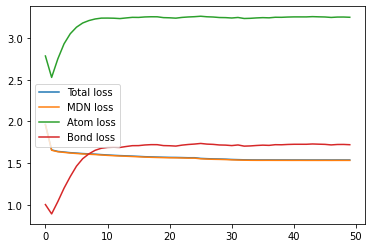

In [6]:
import pandas as pd
history = pd.read_csv('DeepDock_pdbbindv2019_13K_loss.csv')
print(history.columns)

import matplotlib.pyplot as plt
plt.plot(range(len(history)), history['total_loss'], label = 'Total loss')
plt.plot(range(len(history)), history['mdn_loss'], label = 'MDN loss')
plt.plot(range(len(history)), history['atom_loss'], label = 'Atom loss')
plt.plot(range(len(history)), history['bond_loss'], label = 'Bond loss')
plt.legend()

Index(['Unnamed: 0', 'total_loss', 'mdn_loss', 'atom_loss', 'bond_loss',
       'test_total_loss', 'test_mdn_loss', 'test_atom_loss', 'test_bond_loss'],
      dtype='object')


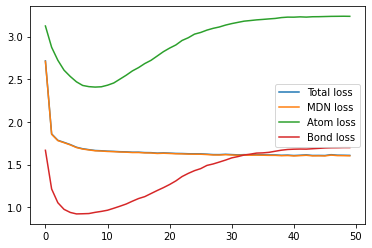

In [12]:
import pandas as pd
history = pd.read_csv('DeepDock_pdbbindv2019_13K_loss.csv')
print(history.columns)

import matplotlib.pyplot as plt
plt.plot(range(len(history)), history['total_loss'], label = 'Total loss')
plt.plot(range(len(history)), history['mdn_loss'], label = 'MDN loss')
plt.plot(range(len(history)), history['atom_loss'], label = 'Atom loss')
plt.plot(range(len(history)), history['bond_loss'], label = 'Bond loss')
plt.legend()

In [ ]:
from torch_geometric.utils import normalized_cut, to_dense_batch
count=0
for batch in loader_train:
    count+=1
    print(count)
    h_t, h_l = batch
    h_l_x, l_mask = to_dense_batch(h_l.x, h_l.batch, fill_value=0)
    h_t_x, t_mask = to_dense_batch(h_t.x, h_t.batch, fill_value=0)
    h_l_pos, _ = to_dense_batch(h_l.pos, h_l.batch, fill_value=0)
    h_t_pos, _ = to_dense_batch(h_t.pos, h_t.batch, fill_value=0)
    assert h_l_x.size(0) == h_t_x.size(0), 'Encountered unequal batch-sizes'
    (B, N_l, C_out), N_t = h_l_x.size(), h_t_x.size(1)
    # Combine and mask
    h_l_x = h_l_x.unsqueeze(-2)
    h_l_x = h_l_x.repeat(1, 1, N_t, 1) # [B, N_l, N_t, C_out]

    h_t_x = h_t_x.unsqueeze(-3)
    h_t_x = h_t_x.repeat(1, N_l, 1, 1) # [B, N_l, N_t, C_out]
    C = torch.cat((h_l_x, h_t_x), -1)
    print(C)

In [ ]:
h_l_x

In [ ]:
y = model(mol_ntwk.to(device), target_mesh.to(device))

In [ ]:
y

In [ ]:
%%time
from datetime import datetime
now = datetime.now()
print(now.strftime("Start date: %d/%m/%Y at %H:%M:%S"))

In [ ]:
from torch_geometric.datasets import OGB_MAG
from torch_geometric.loader import NeighborLoader
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
len(dataset[:400])

In [ ]:
%%time
db_complex = PDBbind_complex_dataset(data_path='data/dataset_CASF-2016_285.tar', 
                                     min_target_nodes=50, max_ligand_nodes=None)
db_complex = db_complex.shuffle()
db_complex_train = db_complex[:15000]
db_complex_test = db_complex[15000:]
pdbIDs_test = [db_complex_test.data[i][3] for i in db_complex_test.indices()]
pdbIDs_train = [db_complex_train.data[i][3] for i in db_complex_train.indices()]
print('Complexes in training set:', len(db_complex_train))
print('Complexes in test set:', len(db_complex_test))